In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img
from tensorflow.keras import callbacks, layers,optimizers,models
import os
from sklearn.metrics import precision_score,recall_score
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [ ]:
# load the cifar dataset from tensorflow
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar100.load_data()

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# normalize the data
train_images, test_images = train_images / 255.0, test_images / 255.0

In [ ]:
# augment the dataset using imagegenrator
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0
)

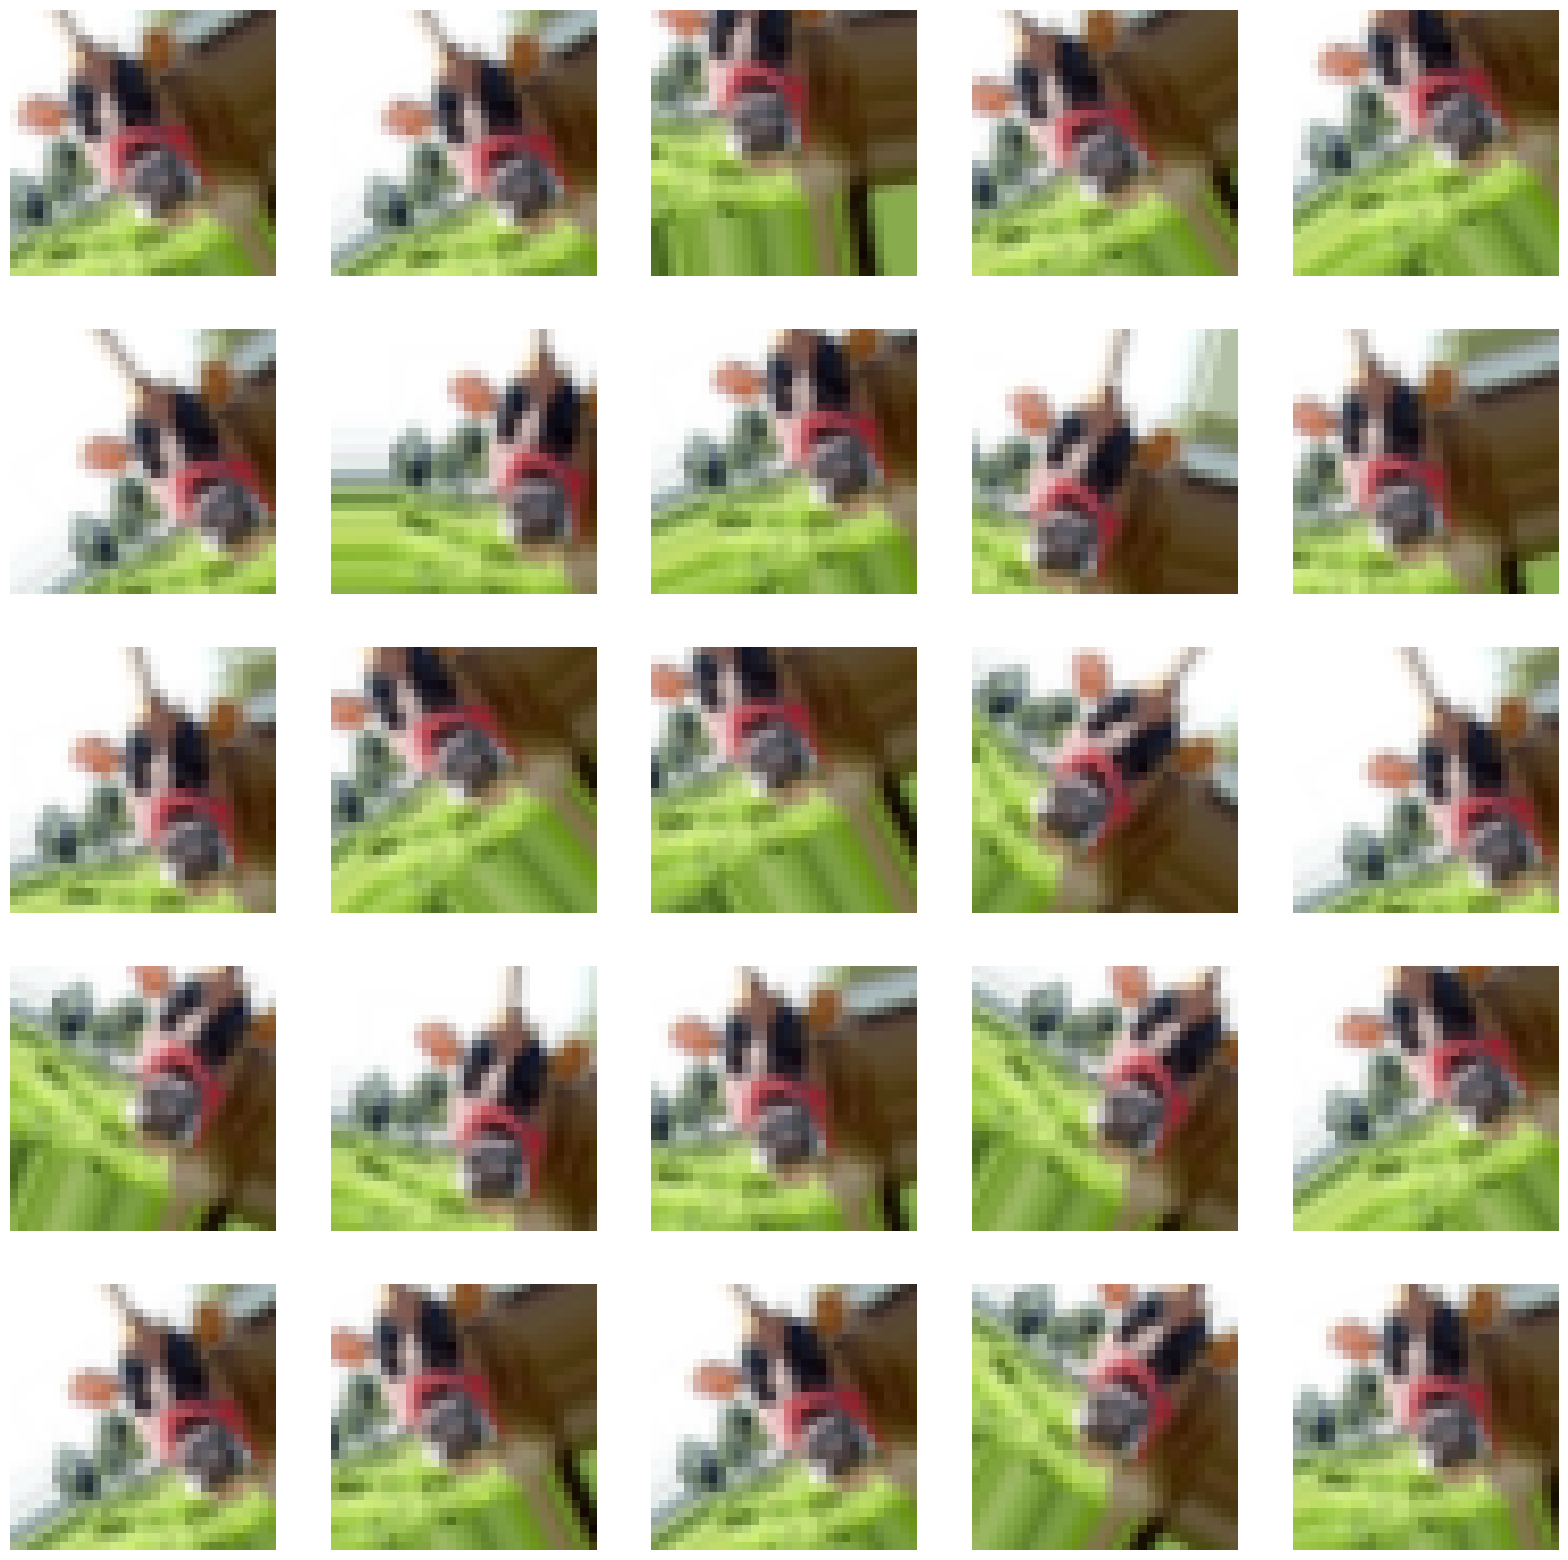

In [ ]:
# view augmented images
sample_image = train_images[0]
sample_image = np.expand_dims(sample_image, axis=0)
gen=datagen.flow(sample_image)
plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(5, 5, i+1)
    batch = next(gen)
    image = array_to_img(batch[0])
    plt.imshow(image)
    plt.axis("off")


In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
# create a base model
def build_model(hp):
  model = models.Sequential()
  model.add(layers.Conv2D(
                          activation='relu',
                          filters=hp.Choice('filters', values=[32,64,128]),
                          kernel_size=hp.Choice('kernel', values = [3,5]),
                          input_shape=(32, 32, 3))
            )
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dropout(hp.Choice('dropout_rate', values=[0.2,0.3,0.4])))
  model.add(layers.Dense(100, activation='softmax'))




  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  return model

In [ ]:
import keras_tuner as kt

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
tuner = kt.GridSearch(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='my_dir',
    project_name='cifar100'
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
tuner.search(train_images,train_labels,validation_data=(test_images,test_labels),epochs=20)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
32                |32                |filters
3                 |3                 |kernel
0.2               |0.2               |dropout_rate

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 51ms/step - accuracy: 0.1367 - loss: 3.8570 - val_accuracy: 0.2709 - val_loss: 3.1002
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 77s 48ms/step - accuracy: 0.3245 - loss: 2.8060 - val_accuracy: 0.3091 - val_loss: 2.8846
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 92s 55ms/step - accuracy: 0.3999 - loss: 2.4470 - val_accuracy: 0.3222 - val_loss: 2.8740
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 126s 45ms/step - accuracy: 0.4522 - loss: 2.1966 - val_accuracy: 0.3357 - val_loss: 2.8253
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 73s 39ms/step - accuracy: 0.4993 - loss: 1.9837 - val_accuracy: 0.3411 - val_loss: 2.8154
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 40ms/step - accuracy: 0.5377 - loss: 1.8249 - val_accuracy: 0.3433 - v

KeyboardInterrupt: 

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'filters': 32, 'kernel': 3, 'dropout_rate': 0.4}


In [ ]:
best_model = tuner.hypermodel.build(best_hps)
history_grid=best_model.fit(train_images,train_labels,epochs=30,validation_data=(test_images,test_labels))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.0178 - loss: 11.3266 - val_accuracy: 0.0272 - val_loss: 4.5418
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.0302 - loss: 4.5075 - val_accuracy: 0.0367 - val_loss: 4.5930
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0521 - loss: 4.3860 - val_accuracy: 0.0330 - val_loss: 4.5545
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0779 - loss: 4.2589 - val_accuracy: 0.0387 - val_loss: 4.6395
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0945 - loss: 4.1483 - val_accuracy: 0.0405 - val_loss: 4.7367
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1219 - loss: 3.9981 - val_accuracy: 0.0521 - val_loss: 4.9237
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1461 - loss: 3.8615 - val_accuracy: 0.0514 - val_loss: 5.0823
Epoch 8/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.1699 - loss: 3.7473 -

In [ ]:
# evaluate model
test_loss, test_acc = best_model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 0s - 1ms/step - accuracy: 0.0611 - loss: 11.2573


In [ ]:
y_pred = best_model.predict(test_images)
precision = precision_score(test_labels,np.argmax(y_pred,axis=1),average='macro')
recall = recall_score(test_labels,np.argmax(y_pred,axis=1),average='macro')
print(f'Precision: {precision}')
print(f'Recall: {recall}'

In [ ]:
# visual performance
plt.plot(history_grid.history['accuracy'], label='accuracy')
plt.plot(history_grid.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

NameError: name 'history_grid' is not defined

In [ ]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.8 MB/s eta 0:00:00


# Bayesian Optimization with optuna

In [ ]:
!pip install optuna --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.5 MB/s eta 0:00:00


In [ ]:
import optuna

In [ ]:
def objective(trial):
  filtera=trial.suggest_categorical('filters', [32,64,128])
  dropout=trial.suggest_uniform('dropout_rate', 0.2,0.5)
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

  # build the model
  model =models.Sequential([
      layers.Conv2D(filters=filtera,kernel_size=(3,3),activation='relu',input_shape=(32,32,3)),
      layers.MaxPooling2D(pool_size=(2,2)),
      layers.Flatten(),
      layers.Dropout(dropout),
      layers.Dense(100,activation='softmax')
  ])
  model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  # train model
  history=model.fit(train_images,train_labels,epochs=10,validation_data=(test_images,test_labels))
  val_accuracy=max(history.history['val_accuracy'])
  return val_accuracy

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
# print the best parameter
print(study.best_params)
print(study.best_value)

[I 2024-12-02 04:53:25,897] A new study created in memory with name: no-name-7eb69a36-1ad3-474c-a13f-7c0578be138b
<ipython-input-15-54c7a303a6d6>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout=trial.suggest_uniform('dropout_rate', 0.2,0.5)
<ipython-input-15-54c7a303a6d6>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activ

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 32ms/step - accuracy: 0.0109 - loss: 11.1772 - val_accuracy: 0.0103 - val_loss: 4.6049
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 79s 31ms/step - accuracy: 0.0107 - loss: 4.6036 - val_accuracy: 0.0102 - val_loss: 4.6051
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - accuracy: 0.0114 - loss: 4.5969 - val_accuracy: 0.0106 - val_loss: 4.6073
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - accuracy: 0.0107 - loss: 4.5983 - val_accuracy: 0.0106 - val_loss: 4.6176
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - accuracy: 0.0117 - loss: 4.5949 - val_accuracy: 0.0104 - val_loss: 4.6095
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 31ms/step - accuracy: 0.0149 - loss: 4.5948 - val_accuracy: 0.0105 - val_loss: 4.6196
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - accuracy: 0.0129 - loss: 4.5919 - val_accuracy: 0.0106 - val_loss: 4.6210
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.0131 

[I 2024-12-02 05:05:59,969] Trial 0 finished with value: 0.010700000450015068 and parameters: {'filters': 32, 'dropout_rate': 0.4749329537150384, 'learning_rate': 0.006917736423327201}. Best is trial 0 with value: 0.010700000450015068.


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 151s 96ms/step - accuracy: 0.0100 - loss: 129.7781 - val_accuracy: 0.0100 - val_loss: 4.6174
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 203s 97ms/step - accuracy: 0.0098 - loss: 4.6195 - val_accuracy: 0.0100 - val_loss: 4.6180
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 202s 97ms/step - accuracy: 0.0107 - loss: 4.6185 - val_accuracy: 0.0100 - val_loss: 4.6167
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 202s 97ms/step - accuracy: 0.0101 - loss: 4.6177 - val_accuracy: 0.0100 - val_loss: 4.6149
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 149s 95ms/step - accuracy: 0.0112 - loss: 4.6168 - val_accuracy: 0.0100 - val_loss: 4.6161
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 202s 96ms/step - accuracy: 0.0091 - loss: 4.6191 - val_accuracy: 0.0100 - val_loss: 4.6174
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 202s 96ms/step - accuracy: 0.0092 - loss: 4.6180 - val_accuracy: 0.0100 - val_loss: 4.6145
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 202s 96ms/step - accuracy

[I 2024-12-02 05:37:57,663] Trial 1 finished with value: 0.009999999776482582 and parameters: {'filters': 128, 'dropout_rate': 0.21516712340974714, 'learning_rate': 0.027029673294915894}. Best is trial 0 with value: 0.010700000450015068.


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 158s 101ms/step - accuracy: 0.0299 - loss: 40.4101 - val_accuracy: 0.1004 - val_loss: 6.4443
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 157s 100ms/step - accuracy: 0.0798 - loss: 6.5509 - val_accuracy: 0.1011 - val_loss: 4.3926
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 198s 98ms/step - accuracy: 0.1131 - loss: 4.3603 - val_accuracy: 0.1469 - val_loss: 3.9667
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 200s 96ms/step - accuracy: 0.1819 - loss: 3.7157 - val_accuracy: 0.1959 - val_loss: 3.6962
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 210s 101ms/step - accuracy: 0.2470 - loss: 3.2681 - val_accuracy: 0.2247 - val_loss: 3.5502
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 193s 95ms/step - accuracy: 0.3063 - loss: 2.9342 - val_accuracy: 0.2519 - val_loss: 3.4388
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 202s 96ms/step - accuracy: 0.3647 - loss: 2.6277 - val_accuracy: 0.2682 - val_loss: 3.3940
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 152s 97ms/step - accura

[I 2024-12-02 06:10:01,548] Trial 2 finished with value: 0.298799991607666 and parameters: {'filters': 128, 'dropout_rate': 0.295033052237775, 'learning_rate': 1.6609424753911178e-05}. Best is trial 2 with value: 0.298799991607666.


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 85s 54ms/step - accuracy: 0.0101 - loss: 463.9231 - val_accuracy: 0.0100 - val_loss: 4.6490
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 54ms/step - accuracy: 0.0103 - loss: 4.6460 - val_accuracy: 0.0100 - val_loss: 4.6386
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 143s 55ms/step - accuracy: 0.0105 - loss: 4.6467 - val_accuracy: 0.0100 - val_loss: 4.6457
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 141s 54ms/step - accuracy: 0.0091 - loss: 4.6456 - val_accuracy: 0.0100 - val_loss: 4.6445
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 148s 58ms/step - accuracy: 0.0090 - loss: 4.6477 - val_accuracy: 0.0100 - val_loss: 4.6402
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 136s 55ms/step - accuracy: 0.0100 - loss: 4.6465 - val_accuracy: 0.0100 - val_loss: 4.6602
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 139s 52ms/step - accuracy: 0.0100 - loss: 4.6462 - val_accuracy: 0.0100 - val_loss: 4.6453
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 52ms/step - accuracy: 

[I 2024-12-02 06:30:45,148] Trial 3 finished with value: 0.009999999776482582 and parameters: {'filters': 64, 'dropout_rate': 0.29407119728575015, 'learning_rate': 0.0930995855257884}. Best is trial 2 with value: 0.298799991607666.


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 53ms/step - accuracy: 0.0099 - loss: 20.4588 - val_accuracy: 0.0100 - val_loss: 4.6087
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 86s 55ms/step - accuracy: 0.0106 - loss: 4.6111 - val_accuracy: 0.0100 - val_loss: 4.6097
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 145s 57ms/step - accuracy: 0.0091 - loss: 4.6113 - val_accuracy: 0.0100 - val_loss: 4.6095
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 141s 57ms/step - accuracy: 0.0094 - loss: 4.6111 - val_accuracy: 0.0100 - val_loss: 4.6092
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 86s 55ms/step - accuracy: 0.0092 - loss: 4.6109 - val_accuracy: 0.0100 - val_loss: 4.6099
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 88s 56ms/step - accuracy: 0.0111 - loss: 4.6111 - val_accuracy: 0.0100 - val_loss: 4.6094
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 141s 56ms/step - accuracy: 0.0099 - loss: 4.6117 - val_accuracy: 0.0100 - val_loss: 4.6086
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 56ms/step - accuracy: 0.0

[I 2024-12-02 06:50:42,871] Trial 4 finished with value: 0.009999999776482582 and parameters: {'filters': 64, 'dropout_rate': 0.48680580695308145, 'learning_rate': 0.011893446083686626}. Best is trial 2 with value: 0.298799991607666.


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 90s 57ms/step - accuracy: 0.0239 - loss: 39.7450 - val_accuracy: 0.0382 - val_loss: 4.8404
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 85s 54ms/step - accuracy: 0.0372 - loss: 4.9392 - val_accuracy: 0.0525 - val_loss: 4.4411
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 143s 55ms/step - accuracy: 0.0632 - loss: 4.3501 - val_accuracy: 0.0970 - val_loss: 4.1773
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 144s 56ms/step - accuracy: 0.1278 - loss: 3.9220 - val_accuracy: 0.1498 - val_loss: 3.9103
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 141s 56ms/step - accuracy: 0.1954 - loss: 3.5304 - val_accuracy: 0.1868 - val_loss: 3.7455
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 144s 57ms/step - accuracy: 0.2479 - loss: 3.2298 - val_accuracy: 0.2060 - val_loss: 3.6532
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 143s 57ms/step - accuracy: 0.2914 - loss: 2.9830 - val_accuracy: 0.2279 - val_loss: 3.5987
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 141s 57ms/step - accuracy: 0

[I 2024-12-02 07:12:35,597] Trial 5 finished with value: 0.26489999890327454 and parameters: {'filters': 64, 'dropout_rate': 0.387165231686222, 'learning_rate': 3.689290103696956e-05}. Best is trial 2 with value: 0.298799991607666.


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 162s 103ms/step - accuracy: 0.0132 - loss: 15.0404 - val_accuracy: 0.0131 - val_loss: 4.5976
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 160s 103ms/step - accuracy: 0.0174 - loss: 4.5733 - val_accuracy: 0.0140 - val_loss: 4.6144
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 203s 103ms/step - accuracy: 0.0260 - loss: 4.5327 - val_accuracy: 0.0136 - val_loss: 4.6419
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 161s 103ms/step - accuracy: 0.0315 - loss: 4.5103 - val_accuracy: 0.0141 - val_loss: 4.6812
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 200s 102ms/step - accuracy: 0.0363 - loss: 4.4860 - val_accuracy: 0.0151 - val_loss: 4.7294
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 202s 102ms/step - accuracy: 0.0396 - loss: 4.4641 - val_accuracy: 0.0159 - val_loss: 4.8322
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 204s 103ms/step - accuracy: 0.0448 - loss: 4.4611 - val_accuracy: 0.0157 - val_loss: 4.9306
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 160s 103ms/step - a

[I 2024-12-02 07:42:47,528] Trial 6 finished with value: 0.017799999564886093 and parameters: {'filters': 128, 'dropout_rate': 0.29815736798081177, 'learning_rate': 0.0024521945685571918}. Best is trial 2 with value: 0.298799991607666.


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 58s 37ms/step - accuracy: 0.0156 - loss: 128.0956 - val_accuracy: 0.0448 - val_loss: 11.1602
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 55s 35ms/step - accuracy: 0.0279 - loss: 12.7358 - val_accuracy: 0.0322 - val_loss: 5.0222
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 79s 33ms/step - accuracy: 0.0273 - loss: 5.2172 - val_accuracy: 0.0314 - val_loss: 4.6356
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - accuracy: 0.0324 - loss: 4.7060 - val_accuracy: 0.0360 - val_loss: 4.5381
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - accuracy: 0.0373 - loss: 4.5401 - val_accuracy: 0.0432 - val_loss: 4.4781
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 33ms/step - accuracy: 0.0496 - loss: 4.4316 - val_accuracy: 0.0532 - val_loss: 4.4278
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - accuracy: 0.0631 - loss: 4.3150 - val_accuracy: 0.0613 - val_loss: 4.3892
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.07

[I 2024-12-02 07:53:32,273] Trial 7 finished with value: 0.09459999948740005 and parameters: {'filters': 32, 'dropout_rate': 0.4677763179078939, 'learning_rate': 3.182390650563041e-05}. Best is trial 2 with value: 0.298799991607666.


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 54s 34ms/step - accuracy: 0.0094 - loss: 12.4248 - val_accuracy: 0.0100 - val_loss: 4.6146
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 33ms/step - accuracy: 0.0098 - loss: 4.6181 - val_accuracy: 0.0100 - val_loss: 4.6166
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 32ms/step - accuracy: 0.0094 - loss: 4.6174 - val_accuracy: 0.0100 - val_loss: 4.6138
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.0098 - loss: 4.6175 - val_accuracy: 0.0100 - val_loss: 4.6159
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 32ms/step - accuracy: 0.0093 - loss: 4.6190 - val_accuracy: 0.0100 - val_loss: 4.6151
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - accuracy: 0.0102 - loss: 4.6177 - val_accuracy: 0.0100 - val_loss: 4.6165
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - accuracy: 0.0115 - loss: 4.6180 - val_accuracy: 0.0100 - val_loss: 4.6159
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 33ms/step - accuracy: 0.0106 

[I 2024-12-02 08:06:10,528] Trial 8 finished with value: 0.009999999776482582 and parameters: {'filters': 32, 'dropout_rate': 0.3876701979184487, 'learning_rate': 0.02792538677100198}. Best is trial 2 with value: 0.298799991607666.


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 88s 56ms/step - accuracy: 0.0109 - loss: 28.7338 - val_accuracy: 0.0100 - val_loss: 4.6211
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 143s 56ms/step - accuracy: 0.0093 - loss: 4.6219 - val_accuracy: 0.0100 - val_loss: 4.6235
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 143s 57ms/step - accuracy: 0.0106 - loss: 4.6236 - val_accuracy: 0.0100 - val_loss: 4.6187
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 57ms/step - accuracy: 0.0104 - loss: 4.6222 - val_accuracy: 0.0100 - val_loss: 4.6183
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 141s 57ms/step - accuracy: 0.0100 - loss: 4.6216 - val_accuracy: 0.0100 - val_loss: 4.6204
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 86s 55ms/step - accuracy: 0.0106 - loss: 4.6219 - val_accuracy: 0.0100 - val_loss: 4.6190
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 55ms/step - accuracy: 0.0091 - loss: 4.6217 - val_accuracy: 0.0100 - val_loss: 4.6218
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 144s 56ms/step - accuracy: 0

[I 2024-12-02 08:28:07,468] Trial 9 finished with value: 0.009999999776482582 and parameters: {'filters': 64, 'dropout_rate': 0.4551190356415734, 'learning_rate': 0.03613128610253412}. Best is trial 2 with value: 0.298799991607666.


{'filters': 128, 'dropout_rate': 0.295033052237775, 'learning_rate': 1.6609424753911178e-05}
0.298799991607666


# using the parameter from Bayesian Optimisation

In [ ]:
# create a model using the paramaters

model_bayes =models.Sequential([
      layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',input_shape=(32,32,3)),
      layers.MaxPooling2D(pool_size=(2,2)),
      layers.Flatten(),
      layers.Dropout(0.4),
      layers.Dense(100,activation='softmax')
  ])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_bayes.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_bayes =model.fit(datagen.flow(train_images,train_labels),epochs=10,validation_data=(test_images,test_labels))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 237s 151ms/step - accuracy: 0.1617 - loss: 3.6381 - val_accuracy: 0.2178 - val_loss: 3.3576
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 219s 140ms/step - accuracy: 0.1747 - loss: 3.5436 - val_accuracy: 0.2373 - val_loss: 3.2597
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 216s 138ms/step - accuracy: 0.1855 - loss: 3.4919 - val_accuracy: 0.2492 - val_loss: 3.2059
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 206s 132ms/step - accuracy: 0.1932 - loss: 3.4350 - val_accuracy: 0.2538 - val_loss: 3.1543
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 216s 138ms/step - accuracy: 0.2008 - loss: 3.3954 - val_accuracy: 0.2563 - val_loss: 3.1279
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 214s 137ms/step - accuracy: 0.2056 - loss: 3.3577 - val_accuracy: 0.2612 - val_loss: 3.1003
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 274s 145ms/step - accuracy: 0.2114 - loss: 3.3329 - val_accuracy: 0.2721 - val_loss: 3.0784
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 225s 144ms/step - accuracy: 0.2

In [ ]:
# evaluate the model performance
test_loss, test_acc = model_bayes.evaluate(test_images,  test_labels, verbose=2)

313/313 - 6s - 20ms/step - accuracy: 0.0098 - loss: 4.6168


In [ ]:
test_acc*100

0.9800000116229057

In [ ]:
y_pred = model_bayes.predict(test_images)
precision = precision_score(test_labels,np.argmax(y_pred,axis=1),average='macro')
recall = recall_score(test_labels,np.argmax(y_pred,axis=1),average='macro')
print(f'Precision: {precision*100}')
print(f'Recall: {recall}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step
Precision: 0.1338798964650483
Recall: 0.0098


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 1.0, 'Model accuracy Bayesian Optimisation')

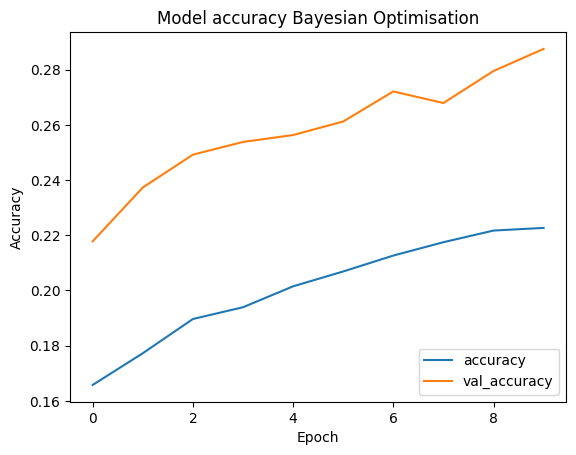

In [ ]:
# visual performance
plt.plot(history_bayes.history['accuracy'], label='accuracy')
plt.plot(history_bayes.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model accuracy Bayesian Optimisation')

# using the parameters from Grid Search

In [ ]:
# using the parameters from Grid Search
model_2 =models.Sequential([
      layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(32,32,3)),
      layers.MaxPooling2D(pool_size=(2,2)),
      layers.Dropout(0.4),

      layers.Conv2D(32,3,activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Dropout(0.4),
      layers.Flatten(),
      layers.Dense(100,activation = 'softmax')
      ])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_2 =model_2.fit(datagen.flow(train_images,train_labels),epochs=10,validation_data=(test_images,test_labels))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 123s 78ms/step - accuracy: 0.1267 - loss: 3.7934 - val_accuracy: 0.2178 - val_loss: 3.3908
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 116s 74ms/step - accuracy: 0.1493 - loss: 3.6156 - val_accuracy: 0.2313 - val_loss: 3.2668
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 114s 73ms/step - accuracy: 0.1697 - loss: 3.5359 - val_accuracy: 0.2570 - val_loss: 3.1589
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 107s 69ms/step - accuracy: 0.1793 - loss: 3.4607 - val_accuracy: 0.2527 - val_loss: 3.1368
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 112s 71ms/step - accuracy: 0.1843 - loss: 3.4209 - val_accuracy: 0.2627 - val_loss: 3.1071
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 141s 71ms/step - accuracy: 0.1944 - loss: 3.3689 - val_accuracy: 0.2811 - val_loss: 3.0350
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 144s 72ms/step - accuracy: 0.1973 - loss: 3.3461 - val_accuracy: 0.2641 - val_loss: 3.0766
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 143s 73ms/step - accuracy: 0.2061 - lo

In [ ]:
# evaluate accuracy
test_loss, test_acc = model_2.evaluate(test_images,  test_labels, verbose=2)

313/313 - 3s - 9ms/step - accuracy: 0.2971 - loss: 2.9473


In [ ]:
y_pred = model_2.predict(test_images)
precision = precision_score(test_labels,np.argmax(y_pred,axis=1),average='macro')
recall = recall_score(test_labels,np.argmax(y_pred,axis=1),average='macro')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Precision: 0.2878218441185676
Recall: 0.2971


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

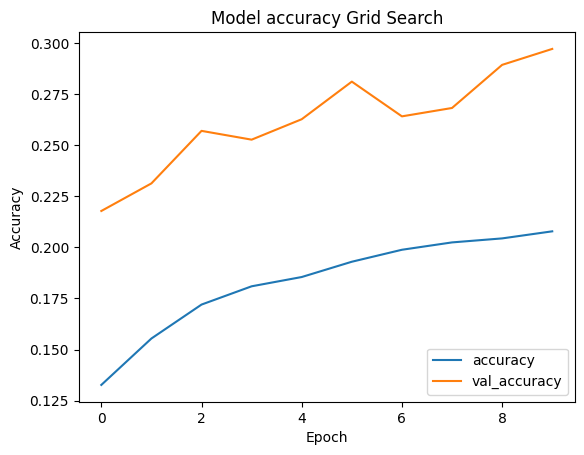

In [ ]:
# view the performance of the model
plt.plot(history_2.history['accuracy'], label='accuracy')
plt.plot(history_2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model accuracy Grid Search')
plt

# Transfer Learning

In [ ]:
from tensorflow.keras.applications import ResNet50, VGG16,MobileNetV2
from tensorflow.keras.utils import to_categorical

In [ ]:
# train_images = to_categorical(train_images)
# test_images = to_categorical(test_images)

# Resnet50

In [ ]:
# load resnet without the top layers
base_model_resnet = ResNet50(include_top=False, input_shape=(32,32,3), weights='imagenet')

# freeze the base model to retain weights
base_model_resnet.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# build a model
model_resnet = models.Sequential([
    base_model_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(100, activation='softmax')
])

In [ ]:
# Compile the model
model_resnet.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# fit the model
history_resnet = model_resnet.fit(train_images,train_labels,epochs=20,validation_data=(test_images,test_labels))

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.3636 - loss: 3.5890 - val_accuracy: 0.3262 - val_loss: 4.3619
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.3797 - loss: 3.5254 - val_accuracy: 0.3281 - val_loss: 4.3457
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.3720 - loss: 3.5623 - val_accuracy: 0.3222 - val_loss: 4.4187
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.3750 - loss: 3.5440 - val_accuracy: 0.3247 - val_loss: 4.4640
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.3745 - loss: 3.5896 - val_accuracy: 0.3250 - val_loss: 4.5789
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.3874 - loss: 3.5192 - val_accuracy: 0.3241 - val_loss: 4.5983
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.3869 - loss: 3.5620 - val_accuracy: 0.3268 - val_loss: 4.6329
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.3836 - loss: 3

In [ ]:
def evaluate_model(model,testX, testy):
	_, test_acc = model.evaluate(testX, testy, verbose=0)
	return test_acc

In [ ]:
def plot_performance(history,title=''):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.title(f'Model accuracy of {title}')

In [ ]:
# evaluate accuracy
test_loss, test_acc = model_resnet.evaluate(test_images,  test_labels, verbose=2)

313/313 - 2s - 7ms/step - accuracy: 0.3166 - loss: 4.3407


# MobileNetV2


In [ ]:
base_model_mobilenet = MobileNetV2(include_top=False, input_shape=(32,32,3), weights='imagenet')

<ipython-input-4-e47c86e6905e>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobilenet = MobileNetV2(include_top=False, input_shape=(32,32,3), weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model_mobilenet.trainable = False

In [ ]:
mobile_net_model = models.Sequential([
    base_model_mobilenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4 ),
    layers.Dense(100, activation='softmax')
])

In [ ]:
mobile_net_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_mobilenet=mobile_net_model.fit(train_images,train_labels,epochs=10,validation_data=(test_images,test_labels))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.0688 - loss: 4.1650 - val_accuracy: 0.0463 - val_loss: 4.3919
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.0745 - loss: 4.1568 - val_accuracy: 0.0451 - val_loss: 4.3994
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.0715 - loss: 4.1612 - val_accuracy: 0.0452 - val_loss: 4.4047
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.0736 - loss: 4.1544 - val_accuracy: 0.0455 - val_loss: 4.4041
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.0726 - loss: 4.1464 - val_accuracy: 0.0451 - val_loss: 4.4081
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.0743 - loss: 4.1458 - val_accuracy: 0.0445 - val_loss: 4.4140
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.0766 - loss: 4.1373 - val_accuracy: 0.0432 - val_loss: 4.4198
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.0739 - loss: 4.

In [ ]:
evaluate_model(mobile_net_model,test_images,test_labels)

0.04320000112056732

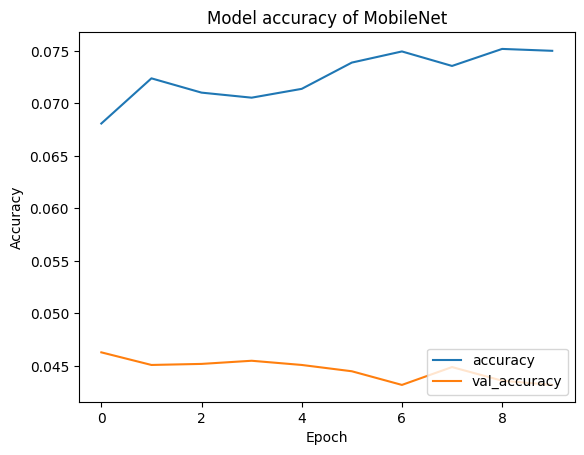

In [ ]:
plot_performance(history_mobilenet,'MobileNet')